<a href="https://colab.research.google.com/github/Ankan1998/Semantic-Segmentation/blob/main/Semantic_Segmentation_FCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import zipfile
import torch
import torchvision
import matplotlib.pyplot as plt
import tensorboard
import numpy as np
from PIL import Image

### **Kaggle preparation**
##### Aerial dataset of kaggle

In [ ]:
from google.colab import files
uploaded=files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 61kB 3.0MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.8-cp36-none-any.whl size=73275 sha256=b6594edad1067ed3c7fdcbdfa54050dce459240169649133abdb64ad48b25fab
  Stored in directory: /root/.cache/pip/wheels/94/a7/09/68dc83c7c14fdbdf5d3f2b2da5b87e587bfc1e85df69b1130c
Successfully built kaggle
  Found existing installation: kaggle 1.5.8
    Uninstalling kaggle-1.5.8:
      Successfully uninstalled kaggle-1.5.8


In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d bulentsiyah/semantic-drone-dataset -p "/tmp"

100% 3.82G/3.83G [01:12<00:00, 39.9MB/s]
100% 3.83G/3.83G [01:12<00:00, 56.6MB/s]


In [ ]:
local_zip='/tmp/semantic-drone-dataset.zip'
zip_ref=zipfile.ZipFile(local_zip,'r')
zip_ref.extractall("/content")
zip_ref.close()

### **Checking with one pair of image**

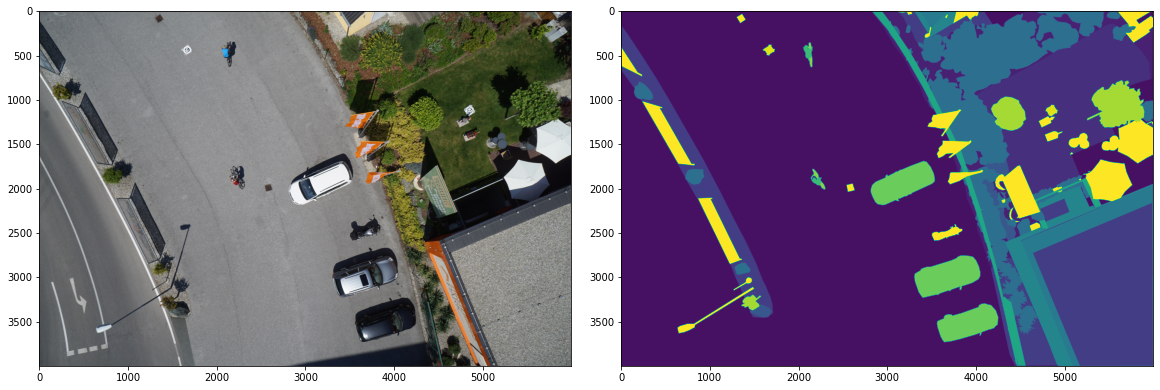

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

original_image = "/content/semantic_drone_dataset/original_images/004.jpg"
label_image_semantic = "/content/semantic_drone_dataset/label_images_semantic/004.png"

fig, axs = plt.subplots(1, 2, figsize=(16, 8), constrained_layout=True)

axs[0].imshow( Image.open(original_image))

axs[1].imshow(Image.open(label_image_semantic))


In [ ]:
im = Image.open(label_image_semantic)
list(np.unique(np.array(im)))

[0, 1, 2, 3, 4, 6, 8, 9, 10, 13, 14, 15, 17, 18, 19, 21, 22]

In [ ]:
import cv2
 
img = cv2.imread('/content/semantic_drone_dataset/original_images/004.jpg', cv2.IMREAD_UNCHANGED)
mask = cv2.imread('/content/semantic_drone_dataset/label_images_semantic/004.png')
dim = (256, 256)
# resize image
resized_mask = cv2.resize(mask, dim)
resized_img = cv2.resize(img, dim)

In [ ]:
np.unique(resized_mask)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22], dtype=uint8)

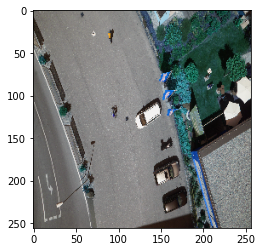

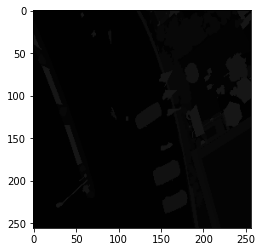

In [ ]:
plt.imshow(resized_img)
plt.show()
plt.imshow(resized_mask)
plt.show()

## **Constructing Custom dataset**

In [ ]:
from torch.utils.data import Dataset, DataLoader, sampler

In [ ]:
"""
def classes(mask_dir):
  mask_file=os.listdir(mask_dir)
  mask_class=[]
  for i in range(len(mask_file)):
    mask_name=os.path.join(mask_dir,mask_file[i])
    mask = Image.open(mask_name)
    mask_class.append(max(list(np.unique(np.array(mask)))))
    print(mask_class)
  return max(mask_class)

  
NUM_OF_CLASSES=classes("/content/semantic_drone_dataset/label_images_semantic")
"""

'\ndef classes(mask_dir):\n  mask_file=os.listdir(mask_dir)\n  mask_class=[]\n  for i in range(len(mask_file)):\n    mask_name=os.path.join(mask_dir,mask_file[i])\n    mask = Image.open(mask_name)\n    mask_class.append(max(list(np.unique(np.array(mask)))))\n    print(mask_class)\n  return max(mask_class)\n\n  \nNUM_OF_CLASSES=classes("/content/semantic_drone_dataset/label_images_semantic")\n'

In [ ]:
NUM_OF_CLASSES=22

In [ ]:
class Satellite_Dataset(Dataset):
    def __init__(self, img_dir,mask_dir,transform=None):
      self.img_dir=img_dir
      self.mask_dir=mask_dir
      self.img_file_list=sorted(os.listdir(img_dir))
      self.mask_file_list=sorted(os.listdir(mask_dir))
      self.transform = transform
        

    def __len__(self):
      return len(self.img_file_list)

    def __getitem__(self, index):
      img_name=os.path.join(self.img_dir, self.img_file_list[index])
      img = Image.open(img_name)
      mask_name=os.path.join(self.mask_dir, self.mask_file_list[index])
      mask = Image.open(mask_name)
      if self.transform:
        img = self.transform(img)
        mask = self.transform(mask)
        mask=torch.squeeze(mask,0)
      return (img,mask)


In [ ]:
from torchvision import transforms
# change the directory accordingly
img_dir="/content/semantic_drone_dataset/original_images"
mask_dir="/content/semantic_drone_dataset/label_images_semantic"
transform_img = transforms.Compose([
                            transforms.Resize((256,256)),
                            transforms.ToTensor()
])

dataset = Satellite_Dataset(img_dir, mask_dir, transform= transform_img)

In [ ]:
len(dataset)

400

In [ ]:
x, y = dataset[10]
x.shape, y.shape

(torch.Size([3, 256, 256]), torch.Size([256, 256]))

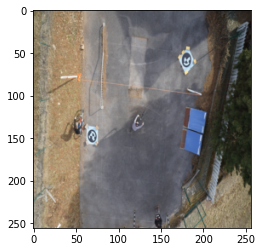

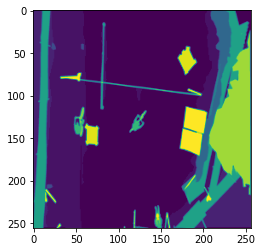

In [ ]:
# permuting to change to (256,256,3)
x=x.permute((1,2,0))
plt.imshow(x)
plt.show()
plt.imshow(y)

In [ ]:
# Splitting into train and val set
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [350, 50])

In [ ]:
# passing into dataloader
train_dl = DataLoader(train_dataset, batch_size=12, shuffle=True)
valid_dl = DataLoader(val_dataset, batch_size=12, shuffle=True)

In [ ]:
xb, yb = next(iter(train_dl))
xb.shape, yb.shape

(torch.Size([12, 3, 256, 256]), torch.Size([12, 256, 256]))

## **VGG model**

In [ ]:
import torchvision.models as models

In [ ]:
fcn_resnet_50=models.segmentation.fcn_resnet50(pretrained=False,progress=True, num_classes=NUM_OF_CLASSES)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [ ]:
print(fcn_resnet_50)

FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
fcn_resnet_50=fcn_resnet_50.to(device)

In [ ]:
#loss function
loss=torch.nn.CrossEntropyLoss()

#optimizer
optimizer=torch.optim.Adam(fcn_resnet_50.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.1)

In [ ]:
epochs = 10
for e in range(epochs):
    running_loss = 0
    for images, labels in train_dl:
        # Flatten MNIST images into a 784 long vector
        #images = images.view(images.shape[0], -1)
        images,labels=images.to(device),labels.to(device)
        # Training pass
        optimizer.zero_grad()
        
        output = fcn_resnet_50(images)["out"]
        lossi = loss(output, labels.long())
        lossi.backward()
        optimizer.step()
        
        running_loss += lossi.item()
    else:
        print(f"Training loss: {running_loss/len(train_dl)}")

TypeError: ignored